In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
data = './'
results_file = './scanpy/Scanpy Ozge Nov2019 new version scRNAseq_IPN_SNr_GABAn_E16_P0_3plates.h5ad'  # the file that will store the analysis results



scanpy==1.4.5.dev180+g5d6f276 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [2]:
path = '/Users/ozge/Desktop/R scripts_Data_Output /Scanpy'

In [3]:
sc.settings.set_figure_params(dpi=80)

## LOAD DATA

In [4]:
#import pyreadr

dataset = sc.read('./merged_OD_02_total.coutt.tsv').T
spliced = sc.read('./merged_OD_02_spliced.coutt.tsv').T
unspliced = sc.read('./merged_OD_02_unspliced.coutt.tsv').T

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [5]:
adata = dataset
adata.layers['spliced'] = spliced.X
adata.layers['unspliced'] = unspliced.X

In [6]:
# show proportions of spliced/unspliced abundances
scv.utils.show_proportions(adata)
adata

Abundance of ['spliced', 'unspliced']: [0.86 0.14]


AnnData object with n_obs × n_vars = 1152 × 27714 
    layers: 'spliced', 'unspliced'

## Add metadata 

In [7]:
# Set the ERCC_ratio as a category, then remove the ERCC genes
ERCC_genes = adata.var_names.str.startswith('ERCC')
adata.obs['ERCC_genes'] = np.sum(
    adata[:, ERCC_genes].X, axis=1) / np.sum(adata.X, axis=1) 
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts_withERCCmito'] = adata.X.sum(axis=1) #.A1




In [8]:
adata.var['fullname'] = adata.var_names
adata.var['ENS_names'] = adata.var_names.str.split('_').str[0]
adata.var['geneid'] = adata.var_names.str.split('_').str[1]
adata.var['feature'] = adata.var_names.str.split('__').str[1]
adata.var['chr'] = adata.var_names.str.split('__').str[2]

#Calculate number of genes
sc.pp.filter_cells(adata, min_genes=0)

In [9]:
adata

AnnData object with n_obs × n_vars = 1152 × 27714 
    obs: 'ERCC_genes', 'n_counts_withERCCmito', 'n_genes'
    var: 'fullname', 'ENS_names', 'geneid', 'feature', 'chr'
    layers: 'spliced', 'unspliced'

In [10]:
#some averages...
print(np.median(adata.obs['n_counts_withERCCmito']), "median number of reads with ERCC per cell")
print(np.median(adata.obs['n_genes']), "median number of genes per cell")
print(np.median(adata.obs['percent_mito']), "median mito_genes/total")
print(np.median(adata.obs['ERCC_genes']), 'median % are ERCC_genes')

2160.3494 median number of reads with ERCC per cell
858.0 median number of genes per cell
0.40708706 median % are ERCC_genes


In [11]:
non_ERCC_genes_list = [name for name in adata.var_names if not name.startswith('ERCC')]
adata_no_ERCC_genes = adata[:, non_ERCC_genes_list] #
adata_no_ERCC_genes

View of AnnData object with n_obs × n_vars = 1152 × 27622 
    obs: 'ERCC_genes', 'n_counts_withERCCmito', 'n_genes'
    var: 'fullname', 'ENS_names', 'geneid', 'feature', 'chr'
    layers: 'spliced', 'unspliced'

In [12]:
adata = adata_no_ERCC_genes

In [13]:
# Add number of counts
adata.obs['n_counts_with_mito'] = adata.X.sum(axis=1) #.A1

Trying to set attribute `.obs` of view, making a copy.


In [14]:
sc.pp.filter_cells(adata, min_genes=1)
mito_genes = adata.var_names.str.endswith('MT')
#mito_genes = adata.var_names.str.endswith('MT')# adata.var_names["mitochondrial"]
# for each cell compute fraction of counts in mito genes vs. all genes... the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1) #.A1
# add the total counts per cell as observations-annotation to adata

In [15]:
print(np.median(adata.obs['percent_mito']), "median mito_genes/total before filtering, without ERCC")

0.057991683 median mito_genes/total before filtering, without ERCC


In [16]:
#now remove the mito genes so that they dont effect downstream analysis
non_mito_genes_list = [name for name in adata.var_names if not name.endswith('MT')]
adata_no_mito_genes = adata[:, non_mito_genes_list] #mito_genes = adata.var_names.str.endswith('M')
adata_no_mito_genes

View of AnnData object with n_obs × n_vars = 1152 × 27592 
    obs: 'ERCC_genes', 'n_counts_withERCCmito', 'n_genes', 'n_counts_with_mito', 'percent_mito'
    var: 'fullname', 'ENS_names', 'geneid', 'feature', 'chr'
    layers: 'spliced', 'unspliced'

In [17]:
adata = adata_no_mito_genes
## add number of genes
adata.obs['n_counts'] = adata.X.sum(axis=1) #.A1

Trying to set attribute `.obs` of view, making a copy.


In [18]:
adata.var_names = adata.var_names.str.split('_').str[1]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [19]:
adata

AnnData object with n_obs × n_vars = 1152 × 27592 
    obs: 'ERCC_genes', 'n_counts_withERCCmito', 'n_genes', 'n_counts_with_mito', 'percent_mito', 'n_counts'
    var: 'fullname', 'ENS_names', 'geneid', 'feature', 'chr'
    layers: 'spliced', 'unspliced'

In [20]:
adata.var_names_make_unique()  # this is unnecessary if using 'gene_ids'

In [21]:
#Calculate number of genes and remove 0 values
sc.pp.filter_cells(adata, min_genes=1)
#ribo
percent_ribo = adata.var_names.str.startswith('Rp')
adata.obs['percent_ribo'] = np.sum(
    adata[:, percent_ribo].X, axis=1) / np.sum(adata.X, axis=1) 

In [22]:
#add the % of protein coding genes 
# Once .raw is this, this can be used to calculate as well
#protein_coding_names = adata.raw.var_names[adata.raw.var['feature'] == 'protein_coding']
adata.obs['percent_coding'] = np.sum(
    adata.X[:,adata.var['feature'] == 'protein_coding'], axis=1) / np.sum(adata.X, axis=1) 

#add the % of lincRNA genes 
#lincRNA_names = adata.raw.var_names[adata.raw.var['feature'] == 'lincRNA']
adata.obs['percent_lincRNA'] = np.sum(
    adata.X[:,adata.var['feature'] == 'lincRNA'], axis=1) / np.sum(adata.X, axis=1)
adata.obs['sum_lincRNA'] = np.sum(
    adata.X[:,adata.var['feature'] == 'lincRNA'], axis=1) 

#add the % of antisense genes 
#antisense_names = adata.raw.var_names[adata.raw.var['feature'] == 'antisense']
adata.obs['percent_antisense'] = np.sum(
    adata.X[:,adata.var['feature'] == 'antisense'], axis=1) / np.sum(adata.X, axis=1)
adata.obs['sum_antisense'] = np.sum(
    adata.X[:,adata.var['feature'] == 'antisense'], axis=1) 

#add the % of antisense genes 
#miRNA_names = adata.raw.var_names[adata.raw.var['feature'] == 'miRNA']
adata.obs['percent_miRNA'] = np.sum(
    adata.X[:,adata.var['feature'] == 'miRNA'], axis=1) / np.sum(adata.X, axis=1) #.A1
adata.obs['sum_miRNA'] = np.sum(
    adata.X[:,adata.var['feature'] == 'miRNA'], axis=1)

#add the % of antisense genes 
#bidirectional_promoter_lncRNA_names = adata.raw.var_names[adata.raw.var['feature'] == 'bidirectional_promoter_lncRNA']
adata.obs['percent_bidirectional_promoter_lncRNA'] = np.sum(
    adata.X[:,adata.var['feature'] == 'bidirectional_promoter_lncRNA'], axis=1) / np.sum(adata.X, axis=1) #.A1
adata.obs['sum_bidirectional_promoter_lncRNA'] = np.sum(
    adata.X[:,adata.var['feature'] == 'bidirectional_promoter_lncRNA'], axis=1) 

#snoRNA_names = adata.raw.var_names[adata.raw.var['feature'] == 'snoRNA']
adata.obs['percent_snoRNA'] = np.sum(
    adata.X[:,adata.var['feature'] == 'snoRNA'], axis=1) / np.sum(adata.X, axis=1) #.A1

#pseudogene
#misc_RNA
#sense_intronic
#sense_overlapping
#rRNA
#ribozyme
#transcribed_unprocessed_pseudogene
#transcribed_unitary_pseudogene
#transcribed_processed_pseudogene
#unprocessed_pseudogene
#unitary_pseudogene

In [23]:
#some averages...
print(np.median(adata.obs['ERCC_genes']), 'median % are ERCC_genes before filtering')
print(np.median(adata.obs['percent_mito']), "median mito_genes/total before filtering, without ERCC")
print(np.median(adata.obs['n_counts_withERCCmito']), "median number of reads with ERCC per cell")
print(np.median(adata.obs['n_counts_with_mito']), "median number of reads without ERCC per cell")
print(np.median(adata.obs['n_counts']), "median number of reads per cell, without ERCC and mito")
print(np.median(adata.obs['percent_ribo']), "median percent of ribosomal genes per cell")
print(np.median(adata.obs['n_genes']), "median number of genes per cell, without ERCC and mito")
print(np.median(adata.obs['percent_coding']), "median percent of protein_coding genes per cell")
print(np.median(adata.obs['percent_lincRNA']), "median percent of lincRNA genes per cell")
print(np.median(adata.obs['percent_antisense']), "median percent of antisense genes per cell")
print(np.median(adata.obs['percent_miRNA']), "median percent of miRNA genes per cell")
print(np.median(adata.obs['percent_bidirectional_promoter_lncRNA']), "median percent of bidirectional_promoter_lncRNA genes per cell")
print(np.median(adata.obs['percent_snoRNA']), "median percent of snoRNA genes per cell")
print(np.median(adata.obs['sum_miRNA']), "median or total miRNA genes per cell")
print(np.median(adata.obs['sum_antisense']), "median or total miRNA genes per cell")
print(np.median(adata.obs['sum_lincRNA']), "median or total miRNA genes per cell")



0.40708706 median % are ERCC_genes before filtering
0.057991683 median mito_genes/total before filtering, without ERCC
2160.3494 median number of reads with ERCC per cell
1164.825 median number of reads without ERCC per cell
1027.0933 median number of reads per cell, without ERCC and mito
0.00790467 median percent of ribosomal genes per cell
814.5 median number of genes per cell, without ERCC and mito
0.959232 median percent of protein_coding genes per cell
0.016598722 median percent of lincRNA genes per cell
0.0027179434 median percent of antisense genes per cell
0.0012963922 median percent of miRNA genes per cell
0.00015233946 median percent of bidirectional_promoter_lncRNA genes per cell
0.0 median percent of snoRNA genes per cell
2.0 median or total miRNA genes per cell
4.0 median or total miRNA genes per cell
16.503056 median or total miRNA genes per cell


In [24]:
#Set some column values as well
#adata.obs
#adata.obs_names
#['fullname'] = adata.var_names
#adata.var['chr'] = adata.var['fullname'].str.split('__').str[2]
adata.obs['stage'] = adata.obs_names.str.split('__').str[0].str.split('_').str[1]
adata.obs['plate'] = adata.obs_names.str.split('__').str[1].str.split('_').str[1]
adata.obs['well_no'] = adata.obs_names.str.split('__').str[2]

In [25]:
adata.obs['plate']

OD_02___plate1__X001    plate1
OD_02___plate1__X002    plate1
OD_02___plate1__X003    plate1
OD_02___plate1__X004    plate1
OD_02___plate1__X005    plate1
                         ...  
OD_05___plate3__X380    plate3
OD_05___plate3__X381    plate3
OD_05___plate3__X382    plate3
OD_05___plate3__X383    plate3
OD_05___plate3__X384    plate3
Name: plate, Length: 1152, dtype: object

In [26]:
print(adata.n_vars)
print(adata.obs_names)
print(adata.var_names)

27592
Index(['OD_02___plate1__X001', 'OD_02___plate1__X002', 'OD_02___plate1__X003',
       'OD_02___plate1__X004', 'OD_02___plate1__X005', 'OD_02___plate1__X006',
       'OD_02___plate1__X007', 'OD_02___plate1__X008', 'OD_02___plate1__X009',
       'OD_02___plate1__X010',
       ...
       'OD_05___plate3__X375', 'OD_05___plate3__X376', 'OD_05___plate3__X377',
       'OD_05___plate3__X378', 'OD_05___plate3__X379', 'OD_05___plate3__X380',
       'OD_05___plate3__X381', 'OD_05___plate3__X382', 'OD_05___plate3__X383',
       'OD_05___plate3__X384'],
      dtype='object', length=1152)
Index(['Gnai3', 'Cdc45', 'H19', 'Scml2', 'Apoh', 'Narf', 'Cav2', 'Klf6',
       'Scmh1', 'Cox5a',
       ...
       'AC109204.1', 'AC097366.1', 'AC130529.1', 'CT009702.1', 'AC034116.5',
       'CT030713.2', 'AC150035.3', 'AC164314.2', 'AC131339.4', 'AC110534.5'],
      dtype='object', length=27592)


... storing 'stage' as categorical
... storing 'plate' as categorical
... storing 'well_no' as categorical
... storing 'geneid' as categorical
... storing 'feature' as categorical
... storing 'chr' as categorical


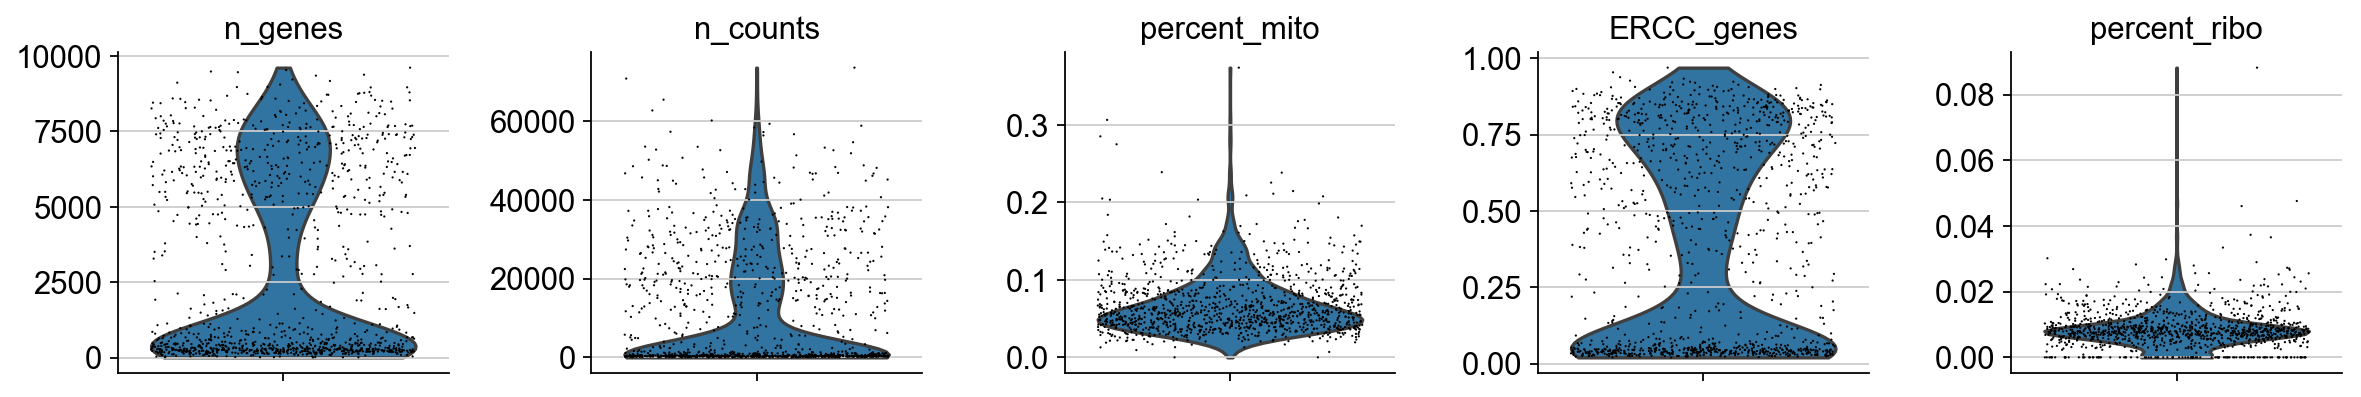

In [27]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito','ERCC_genes','percent_ribo'],
             jitter=0.4, multi_panel=True, save= "prefilter_all.pdf")

In [28]:
sc.pl.violin(adata[adata.obs['plate'] == 'plate1'], ['n_genes', 'n_counts', 'percent_mito','ERCC_genes','percent_ribo'],
             jitter=0.4, multi_panel=True, save= "prefilter_plate1.pdf")

In [29]:
sc.pl.violin(adata[adata.obs['plate'] == 'plate2'], ['n_genes', 'n_counts', 'percent_mito','ERCC_genes','percent_ribo'],
             jitter=0.4, multi_panel=True, save= "prefilter_plate2.pdf")

In [30]:
sc.pl.violin(adata[adata.obs['plate'] == 'plate3'], ['n_genes', 'n_counts', 'percent_mito','ERCC_genes','percent_ribo'],
             jitter=0.4, multi_panel=True, save= "prefilter_plate3.pdf")

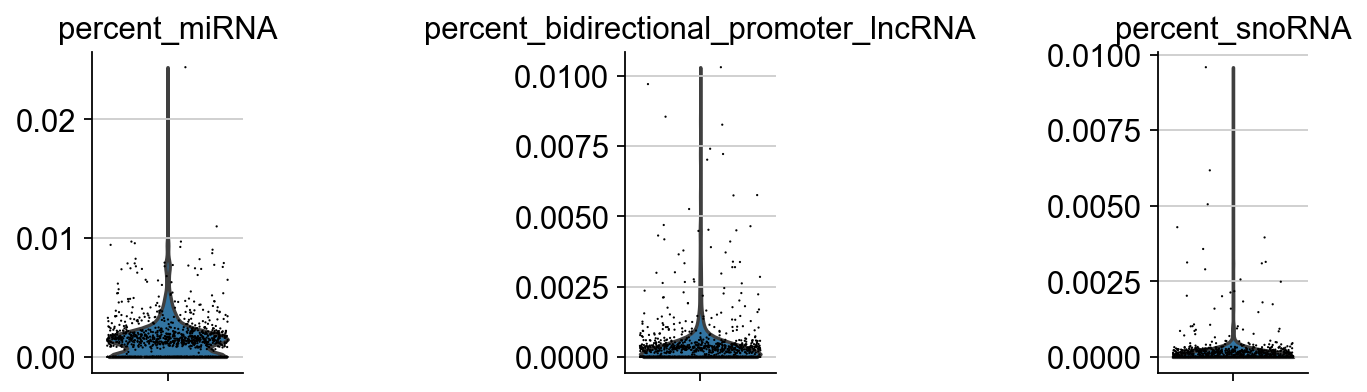

In [31]:
sc.pl.violin(adata, ['percent_coding', 'percent_lincRNA', 'percent_antisense'],
             jitter=0.4, multi_panel=True)
sc.pl.violin(adata, [ 'percent_miRNA', 'percent_bidirectional_promoter_lncRNA', 'percent_snoRNA'],
             jitter=0.4, multi_panel=True)
sc.pl.violin(adata, ['sum_antisense', 'sum_lincRNA', 'sum_bidirectional_promoter_lncRNA'],
             jitter=0.4, multi_panel=True)

In [32]:
#save a backup
adata_backup = adata

## Preprocessing

Show those genes that yield the highest fraction of counts in each single cells, across all cells.

In [33]:
sc.pl.highest_expr_genes(adata, n_top=20)

Normalizing counts per cell.
    finished (0:00:00):normalized adata.X


Basic filtering.

In [34]:
adata_backup = adata

In [35]:
sc.pp.filter_cells(adata, min_genes=2000) #keep this high
sc.pp.filter_genes(adata, min_cells=3)

filtered out 660 cells that have less than 2000 genes expressed
filtered out 7180 genes that are detected in less than 3 cells


In [36]:
adata

AnnData object with n_obs × n_vars = 492 × 20412 
    obs: 'ERCC_genes', 'n_counts_withERCCmito', 'n_genes', 'n_counts_with_mito', 'percent_mito', 'n_counts', 'percent_ribo', 'percent_coding', 'percent_lincRNA', 'sum_lincRNA', 'percent_antisense', 'sum_antisense', 'percent_miRNA', 'sum_miRNA', 'percent_bidirectional_promoter_lncRNA', 'sum_bidirectional_promoter_lncRNA', 'percent_snoRNA', 'stage', 'plate', 'well_no'
    var: 'fullname', 'ENS_names', 'geneid', 'feature', 'chr', 'n_cells'
    layers: 'spliced', 'unspliced'

In [37]:
#some averages after the filtering...
print(np.median(adata.obs['ERCC_genes']), 'median % are ERCC_genes before filtering')
print(np.median(adata.obs['percent_mito']), "median mito_genes/total before filtering, without ERCC")
print(np.median(adata.obs['n_counts_withERCCmito']), "median number of reads with ERCC per cell")
print(np.median(adata.obs['n_counts_with_mito']), "median number of reads without ERCC per cell")
print(np.median(adata.obs['n_counts']), "median number of reads per cell, without ERCC and mito")
print(np.median(adata.obs['percent_ribo']), "median percent of ribosomal genes per cell")
print(np.median(adata.obs['n_genes']), "median number of genes per cell, without ERCC and mito")
print(np.median(adata.obs['percent_coding']), "median percent of protein_coding genes per cell")
print(np.median(adata.obs['percent_lincRNA']), "median percent of lincRNA genes per cell")
print(np.median(adata.obs['percent_antisense']), "median percent of antisense genes per cell")
print(np.median(adata.obs['percent_miRNA']), "median percent of miRNA genes per cell")
print(np.median(adata.obs['percent_bidirectional_promoter_lncRNA']), "median percent of bidirectional_promoter_lncRNA genes per cell")
print(np.median(adata.obs['percent_snoRNA']), "median percent of snoRNA genes per cell")
print(np.median(adata.obs['sum_miRNA']), "median or total miRNA genes per cell")
print(np.median(adata.obs['sum_antisense']), "median or total miRNA genes per cell")
print(np.median(adata.obs['sum_lincRNA']), "median or total miRNA genes per cell")



0.042710677 median % are ERCC_genes before filtering
0.04305118 median mito_genes/total before filtering, without ERCC
25652.363 median number of reads with ERCC per cell
24618.57 median number of reads without ERCC per cell
23664.465 median number of reads per cell, without ERCC and mito
0.00798367 median percent of ribosomal genes per cell
6451.0 median number of genes per cell, without ERCC and mito
0.95846313 median percent of protein_coding genes per cell
0.016991906 median percent of lincRNA genes per cell
0.0027039032 median percent of antisense genes per cell
0.0015268391 median percent of miRNA genes per cell
0.0003409579 median percent of bidirectional_promoter_lncRNA genes per cell
0.00014964805 median percent of snoRNA genes per cell
35.026405 median or total miRNA genes per cell
64.51908 median or total miRNA genes per cell
408.64697 median or total miRNA genes per cell


Note you can also use the function `pp.calculate_qc_metrics` to compute the fraction of mitochondrial genes and additional measures.

In [38]:
sc.pp.calculate_qc_metrics(adata, expr_type='counts', var_type='genes', qc_vars=(), percent_top=(50, 100, 200, 500), inplace=True)

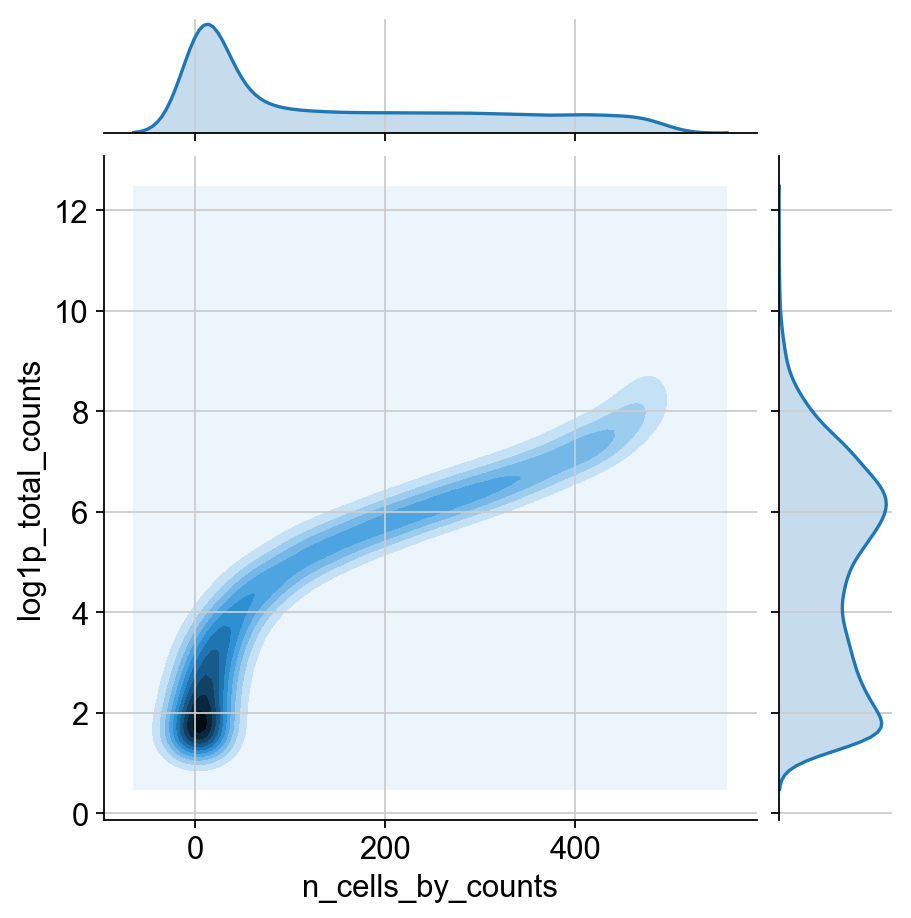

In [39]:
import seaborn as sns
sns.jointplot("pct_dropout_by_counts", "log1p_total_counts", data=adata.var, kind="kde")
sns.jointplot("n_cells_by_counts", "log1p_total_counts", data=adata.var, kind="kde")



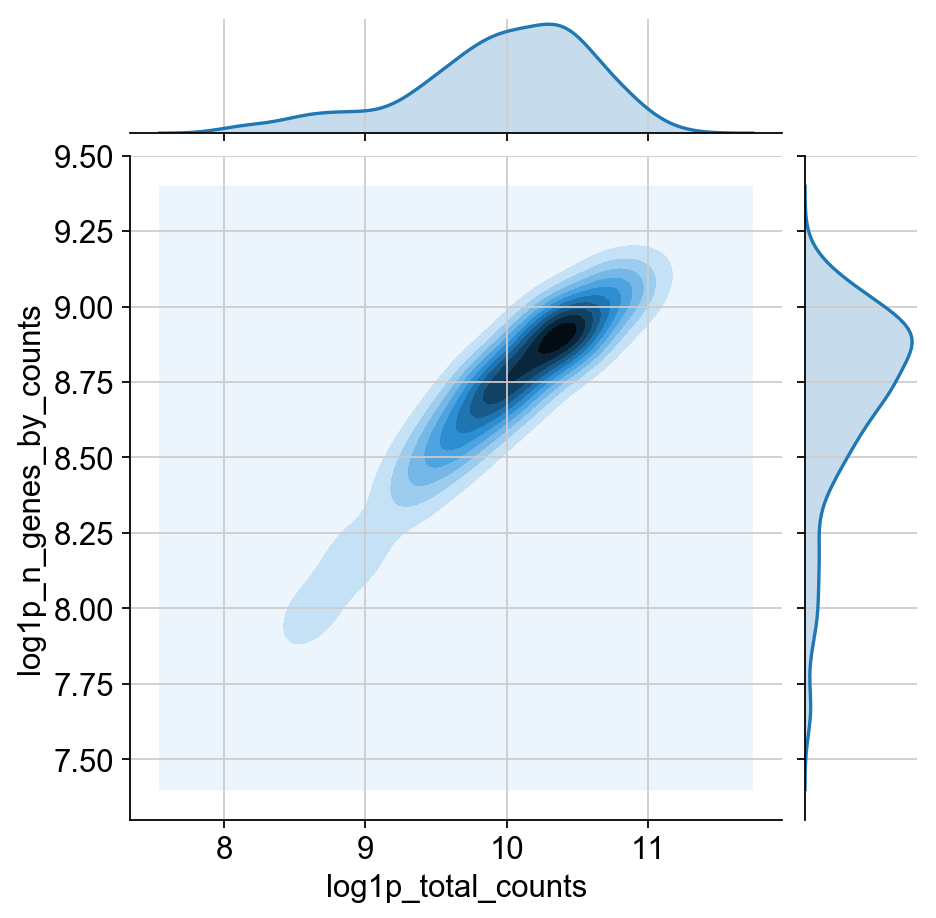

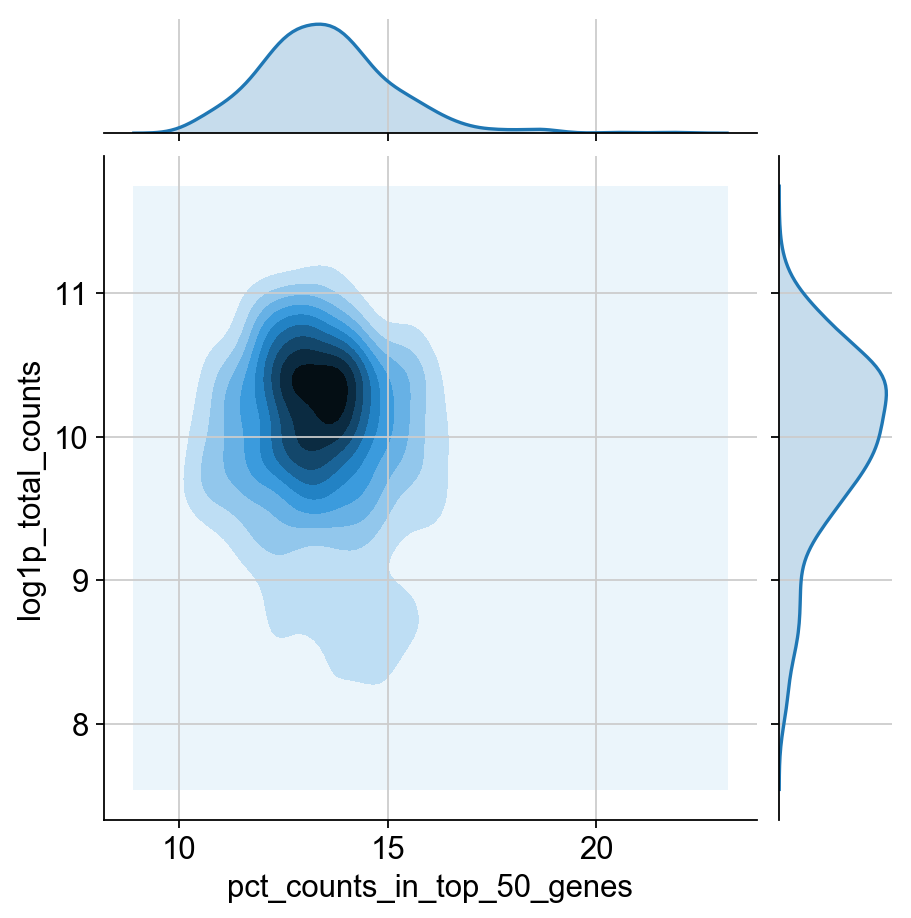

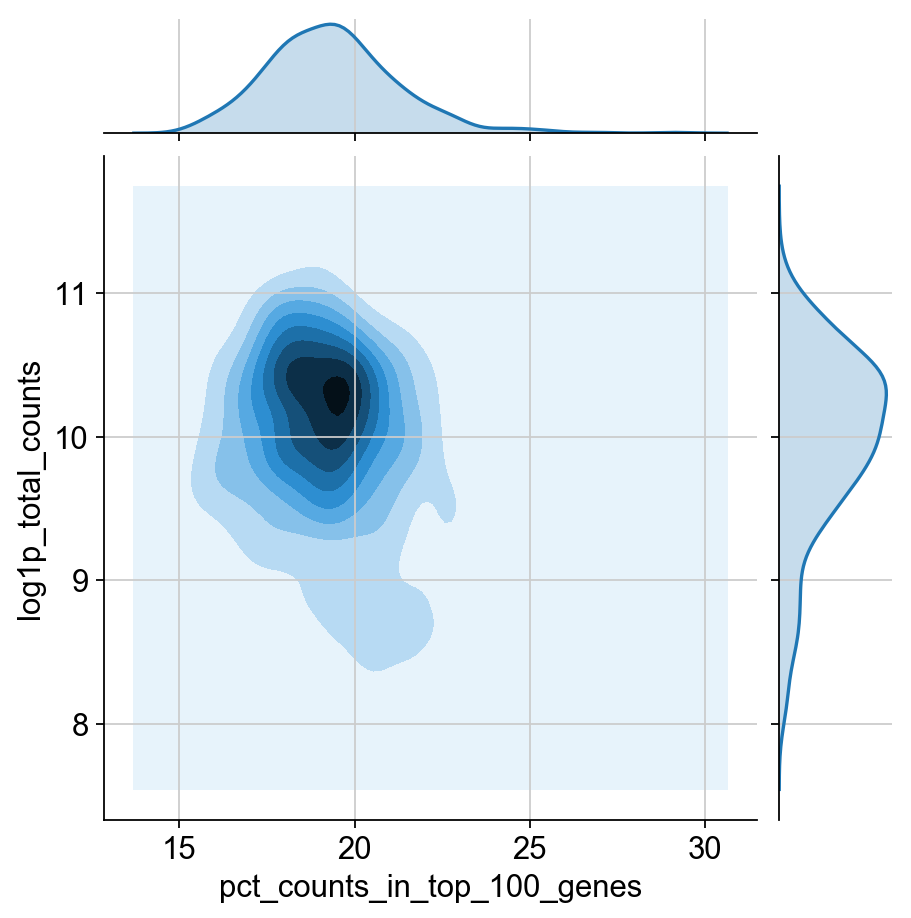

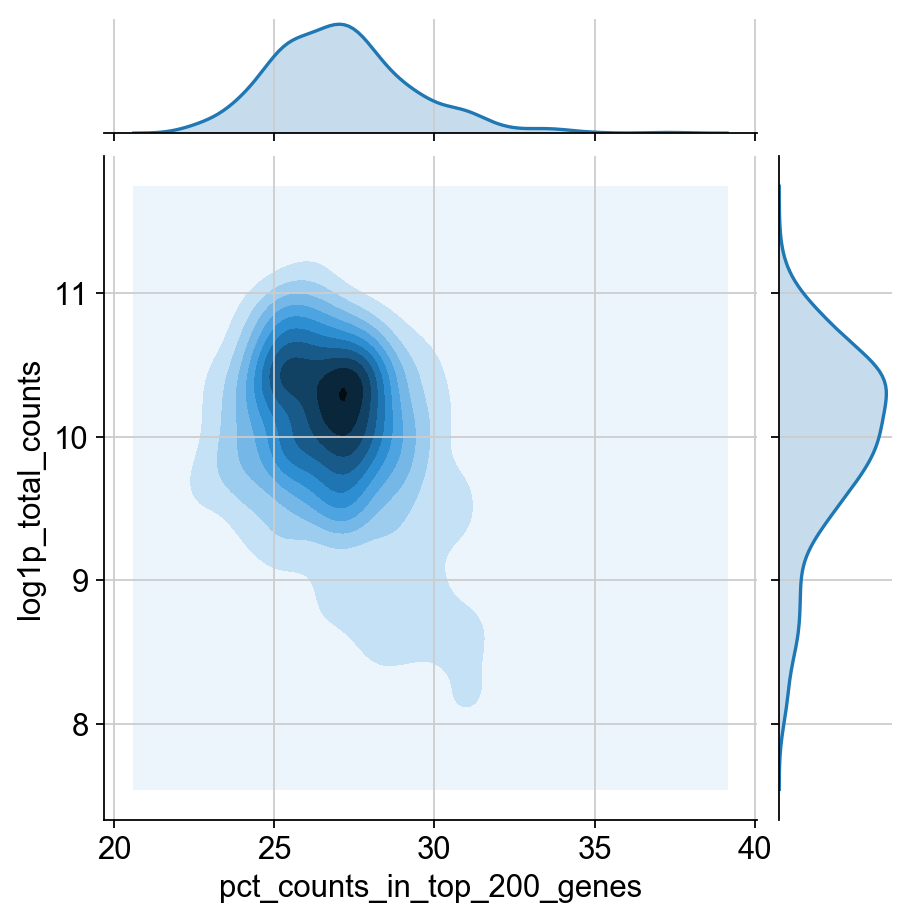

In [40]:
sns.jointplot("log1p_total_counts", "log1p_n_genes_by_counts", data=adata.obs, kind="kde") #hex
sns.jointplot("pct_counts_in_top_50_genes", "log1p_total_counts", data=adata.obs, kind="kde")
sns.jointplot("pct_counts_in_top_100_genes", "log1p_total_counts", data=adata.obs, kind="kde")
sns.jointplot("pct_counts_in_top_200_genes", "log1p_total_counts", data=adata.obs, kind="kde")

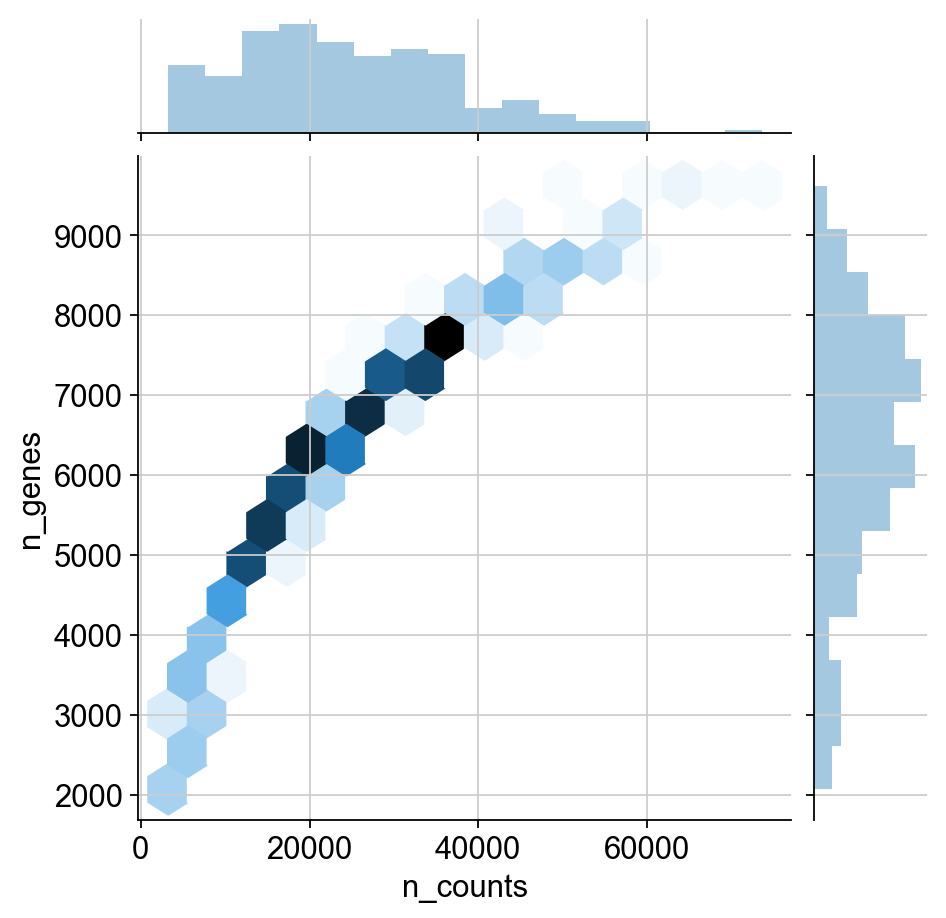

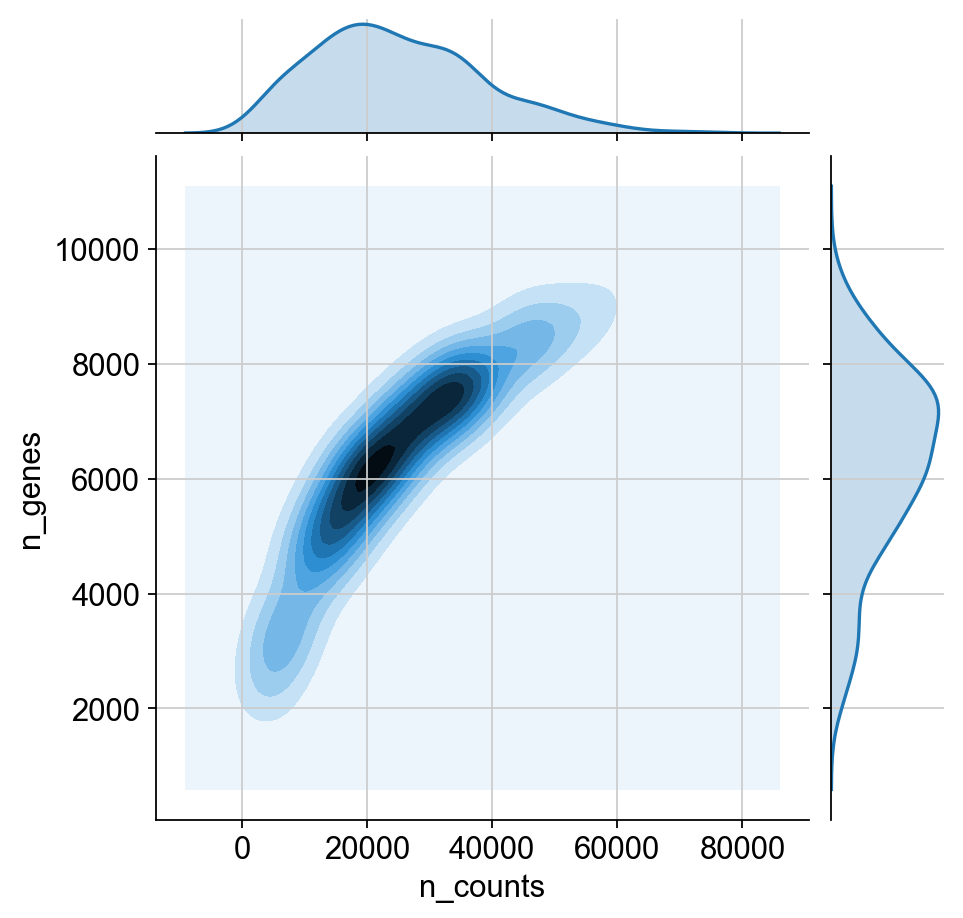

In [41]:
sns.jointplot("n_counts", "n_genes", data=adata.obs, kind="hex")
sns.jointplot("n_counts", "n_genes", data=adata.obs, kind="kde")
#kind : { "scatter" | "reg" | "resid" | "kde" | "hex" }

Remove cells that have too many mitochondrial genes expressed or too many total counts.

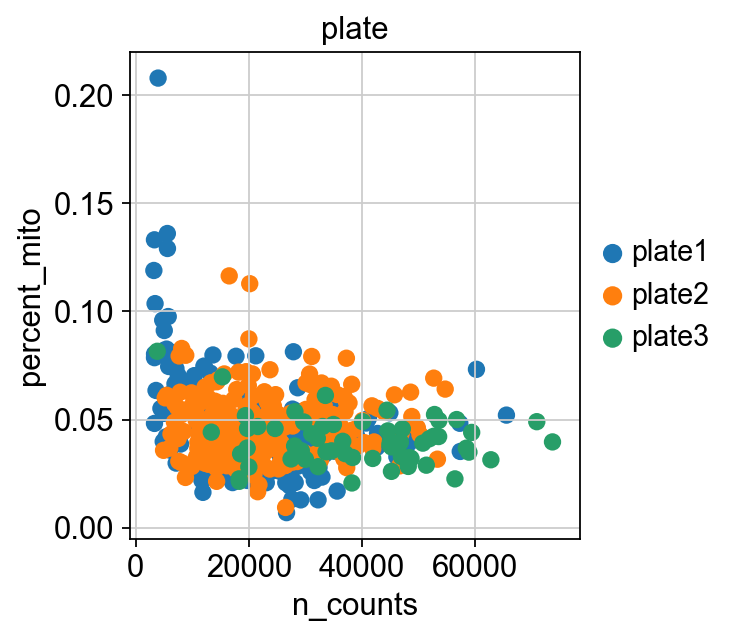

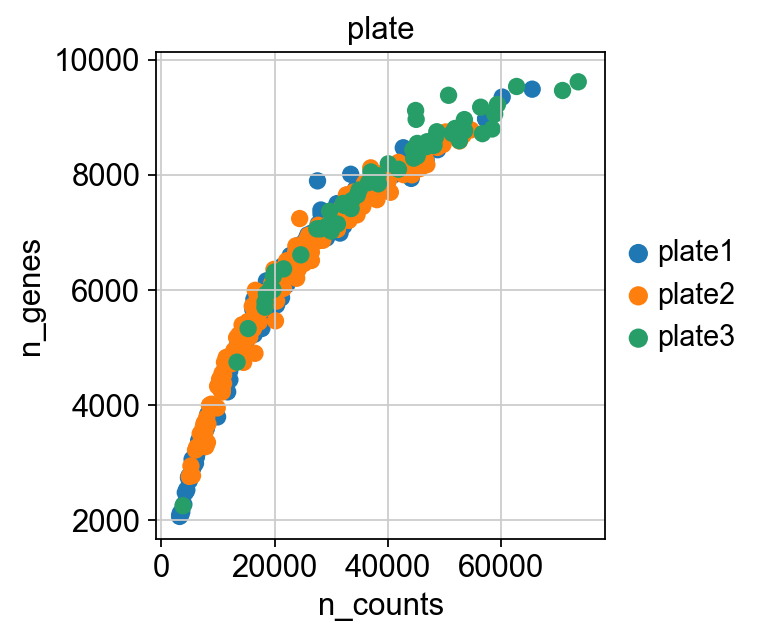

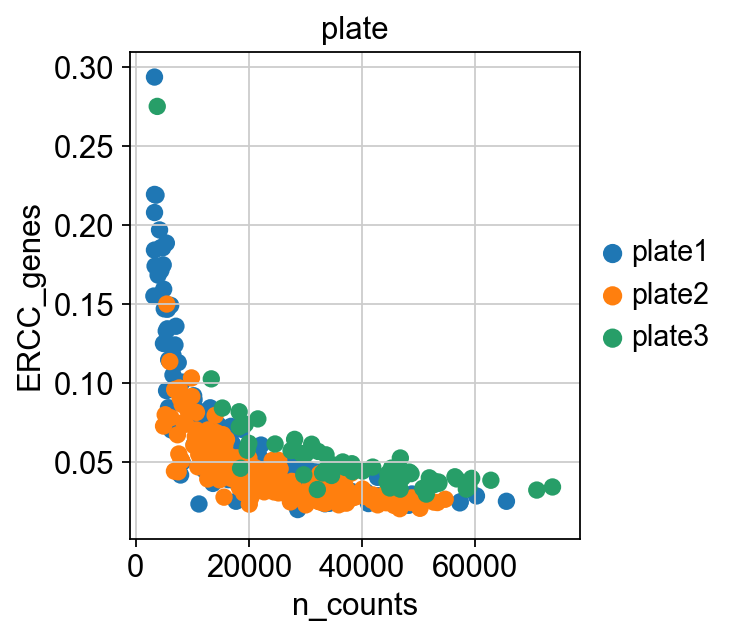

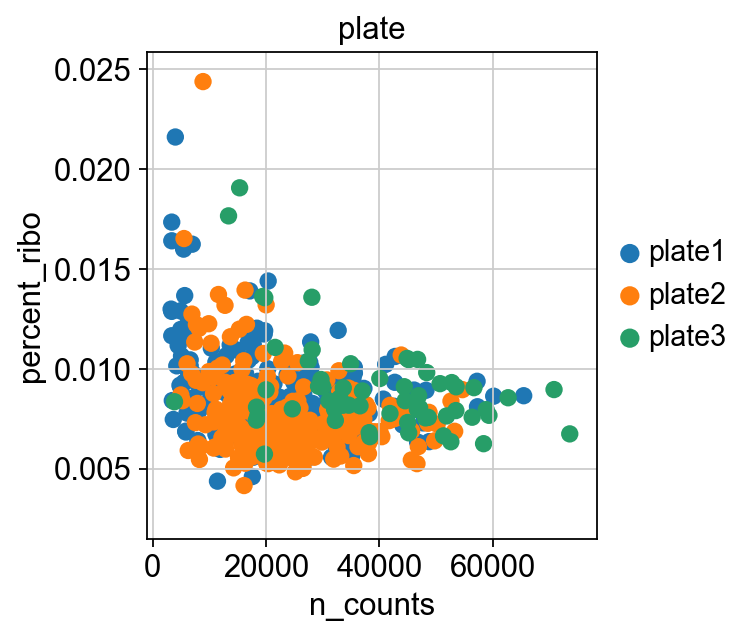

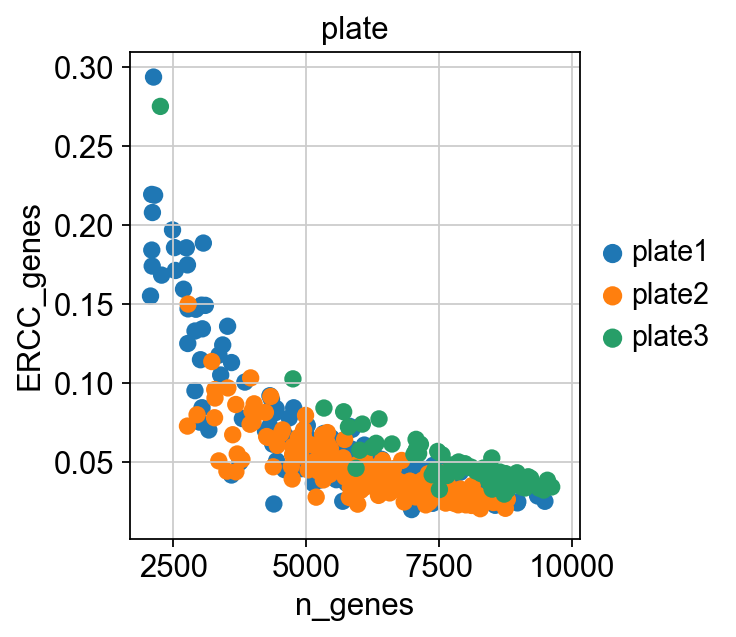

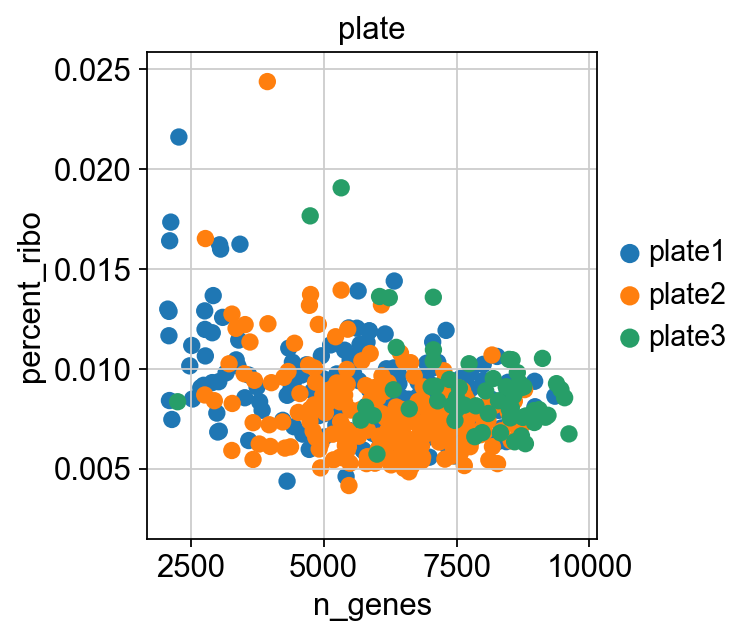

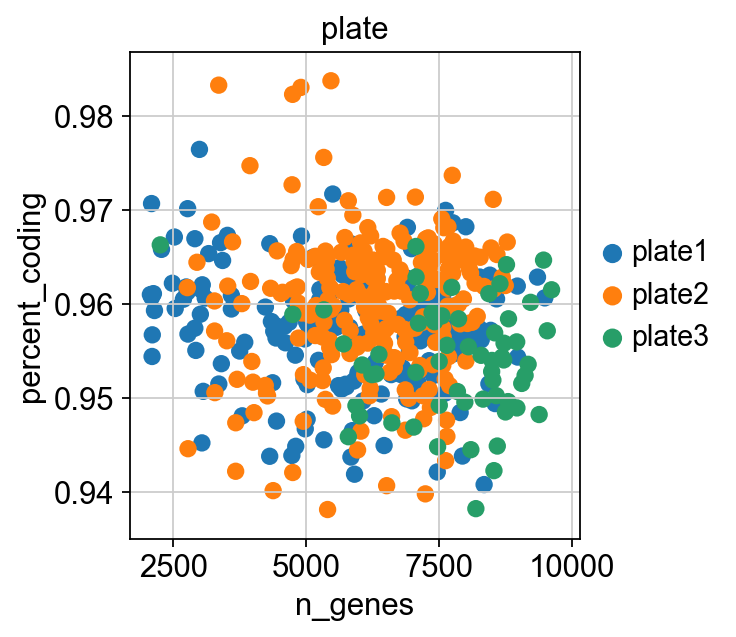

In [42]:
#look at the distribution of categories colored by mito %
sc.pl.scatter(adata, x='n_counts', y='percent_mito',color = 'plate', save= "scatter_plot_prefilter_1.png")
sc.pl.scatter(adata, x='n_counts', y='n_genes',color = 'plate', save= "scatter_plot_prefilter_2.png")
sc.pl.scatter(adata, x='n_counts', y='ERCC_genes',color = 'plate', save= "scatter_plot_prefilter_3.png")
sc.pl.scatter(adata, x='n_counts', y='percent_ribo',color = 'plate', save= "scatter_plot_prefilter_4.png")
sc.pl.scatter(adata, x='n_genes', y='ERCC_genes',color = 'plate', save= "scatter_plot_prefilter_5.png")
sc.pl.scatter(adata, x='n_genes', y='percent_ribo',color = 'plate', save= "scatter_plot_prefilter_6.png")
sc.pl.scatter(adata, x='n_genes', y='percent_coding',color = 'plate', save= "scatter_plot_prefilter_7.png")



Actually do the filtering.

In [43]:
adata

AnnData object with n_obs × n_vars = 492 × 20412 
    obs: 'ERCC_genes', 'n_counts_withERCCmito', 'n_genes', 'n_counts_with_mito', 'percent_mito', 'n_counts', 'percent_ribo', 'percent_coding', 'percent_lincRNA', 'sum_lincRNA', 'percent_antisense', 'sum_antisense', 'percent_miRNA', 'sum_miRNA', 'percent_bidirectional_promoter_lncRNA', 'sum_bidirectional_promoter_lncRNA', 'percent_snoRNA', 'stage', 'plate', 'well_no', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'fullname', 'ENS_names', 'geneid', 'feature', 'chr', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'plate_colors'
    layers: 'spliced', 'unspliced'

In [44]:
adata = adata[adata.obs['n_counts'] < 50000, :] # should remove 3 cells
adata = adata[adata.obs['n_genes'] < 7000, :] #checked the quality of cells with high gene no, looks good
adata = adata[adata.obs['percent_mito'] < 0.1, :]
adata = adata[adata.obs['percent_ribo'] < 0.1, :]
adata = adata[adata.obs['ERCC_genes'] < 0.3, :]
adata = adata[adata.obs['percent_coding'] > 0.85, :]

In [45]:
adata

View of AnnData object with n_obs × n_vars = 461 × 20412 
    obs: 'ERCC_genes', 'n_counts_withERCCmito', 'n_genes', 'n_counts_with_mito', 'percent_mito', 'n_counts', 'percent_ribo', 'percent_coding', 'percent_lincRNA', 'sum_lincRNA', 'percent_antisense', 'sum_antisense', 'percent_miRNA', 'sum_miRNA', 'percent_bidirectional_promoter_lncRNA', 'sum_bidirectional_promoter_lncRNA', 'percent_snoRNA', 'stage', 'plate', 'well_no', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'fullname', 'ENS_names', 'geneid', 'feature', 'chr', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'plate_colors'
    layers: 'spliced', 'unspliced'

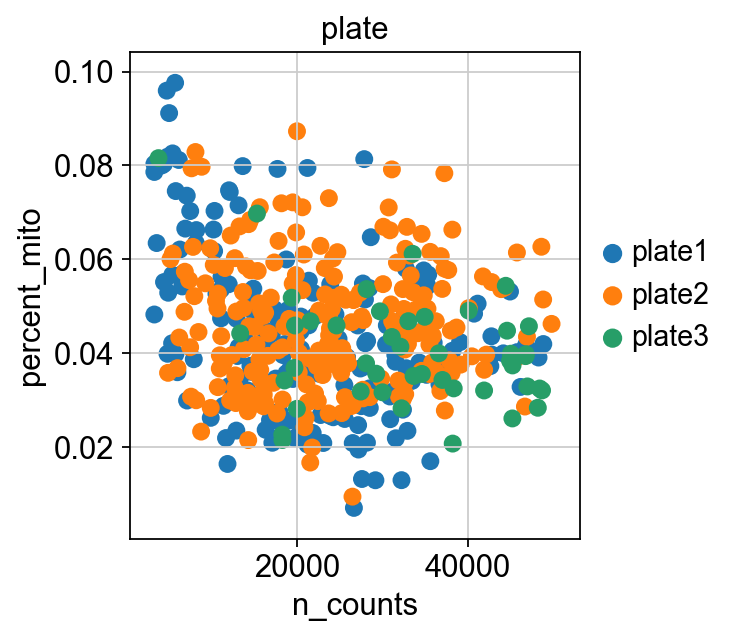

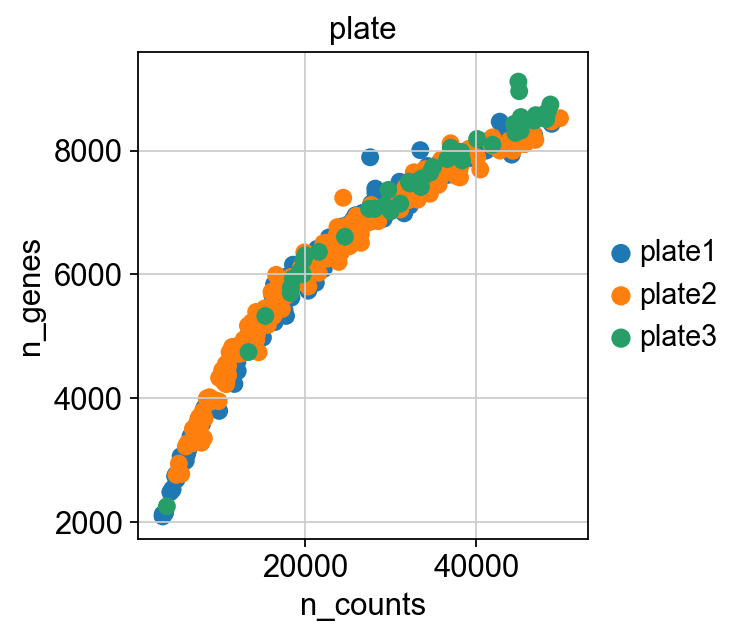

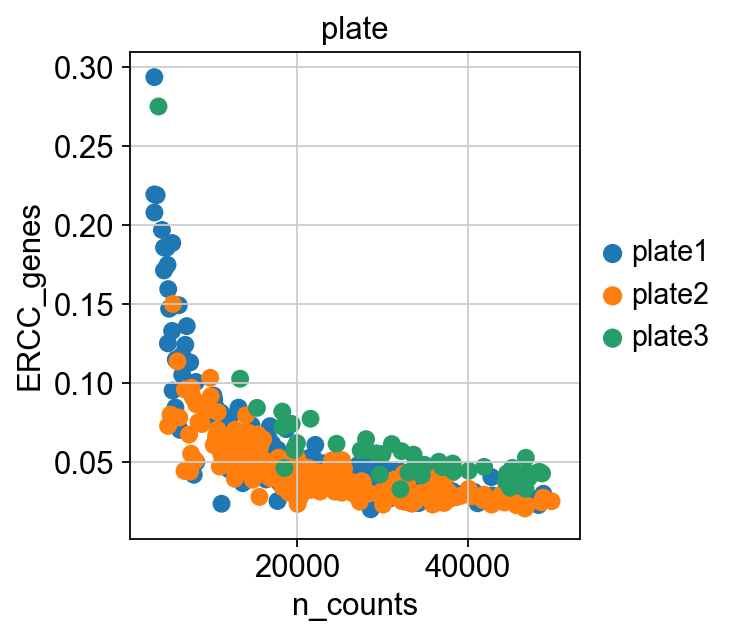

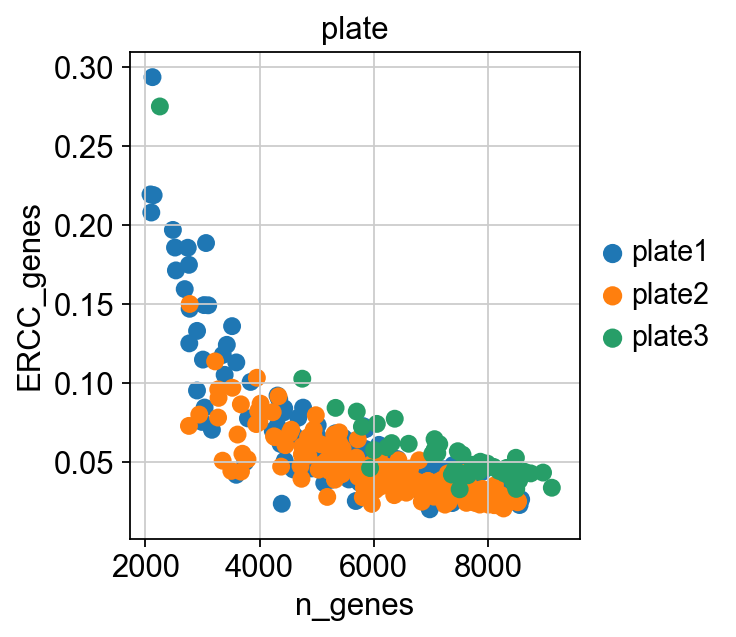

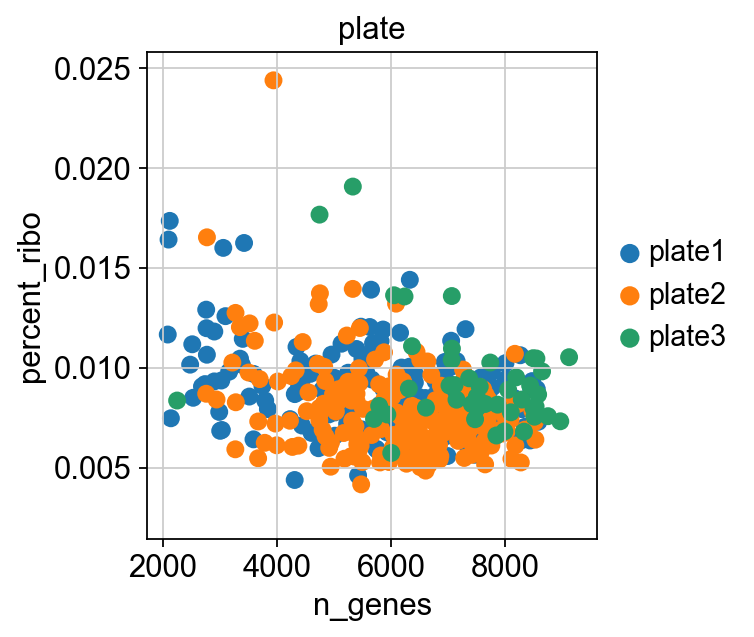

In [46]:
#look at the distribution of categories colored by mito %
sc.pl.scatter(adata, x='n_counts', y='percent_mito',color = 'plate', save= "scatter_plot_filter_1.png")
sc.pl.scatter(adata, x='n_counts', y='n_genes',color = 'plate', save= "scatter_plot_filter_2.png")
sc.pl.scatter(adata, x='n_counts', y='ERCC_genes',color = 'plate', save= "scatter_plot_filter_3.png")
sc.pl.scatter(adata, x='n_counts', y='percent_ribo',color = 'plate', save= "scatter_plotefilter_4.png")
sc.pl.scatter(adata, x='n_genes', y='ERCC_genes',color = 'plate', save= "scatter_plot_filter_5.png")
sc.pl.scatter(adata, x='n_genes', y='percent_ribo',color = 'plate', save= "scatter_plot_filter_6.png")
sc.pl.scatter(adata, x='n_genes', y='percent_coding',color = 'plate', save= "scatter_plot_filter_7.png")



In [47]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito','ERCC_genes','percent_ribo'],
             jitter=0.4, multi_panel=True, save= "filtered.pdf")

# Normalisation

Standard:
Total-count normalize (library-size correct) the data matrix $\mathbf{X}$ to 10,000 reads per cell, so that counts become comparable among cells.

Normalise to a fraction:
Use "fraction=0.9" to take only a certain fraction of genes into account for normalisation, not considering the very highly expressed genes



In [48]:
## Normalize
# Here, only normalise reads in 0.9 fractions of the total
sc.pp.normalize_total(adata,key_added='n_counts_norm')
# This is the classic CPM
#sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

Normalizing counts per cell.
    finished (0:00:00):normalized adata.X


In [49]:
sc.pp.log1p(adata)

Set the `.raw` attribute of AnnData object to the logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object. While many people consider the normalized data matrix as the "relevant data" for visualization and differential testing, some would prefer to store the unnormalized data.

In [50]:
adata.raw = adata

Identify highly-variable genes.

In [51]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [52]:
sc.pl.highly_variable_genes(adata)

Actually do the filtering.

In [53]:
adata = adata[:, adata.var['highly_variable']]

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [54]:
# This regression is not really working
sc.pp.regress_out(adata, ['n_counts','percent_mito'])

regressing out ['n_counts', 'percent_mito']
    finished (0:00:07)


Scale each gene to unit variance. Clip values exceeding standard deviation 10. 

In [55]:
sc.pp.scale(adata, max_value=10)

## Principal component analysis


Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [56]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)


We can make a scatter plot in the PCA coordinates, but we will not use that later on.

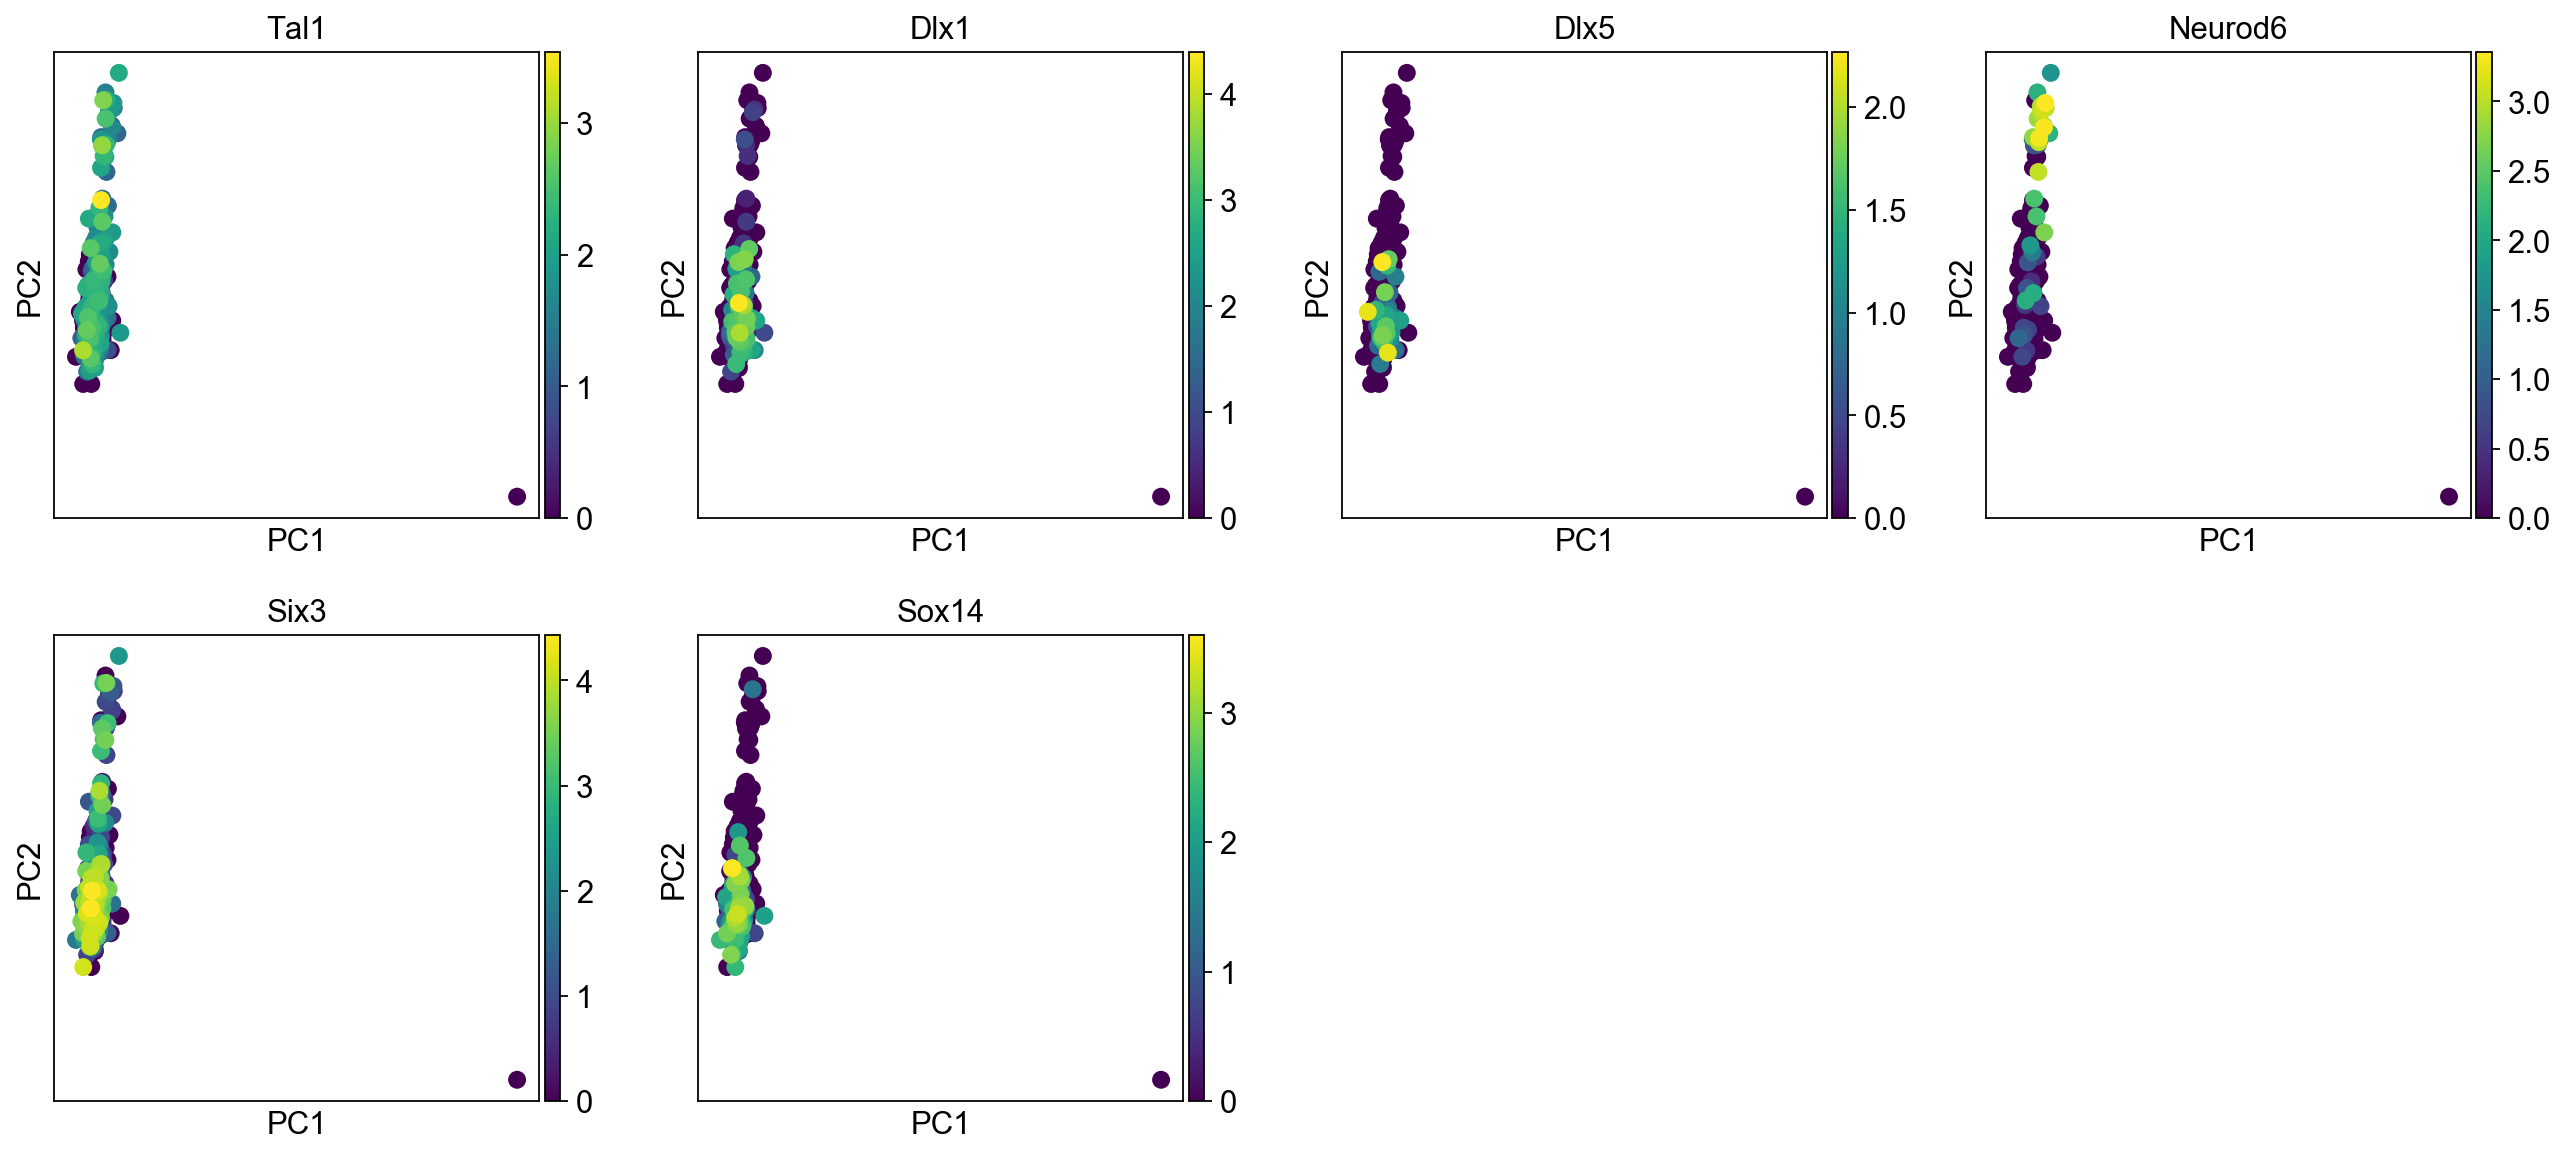

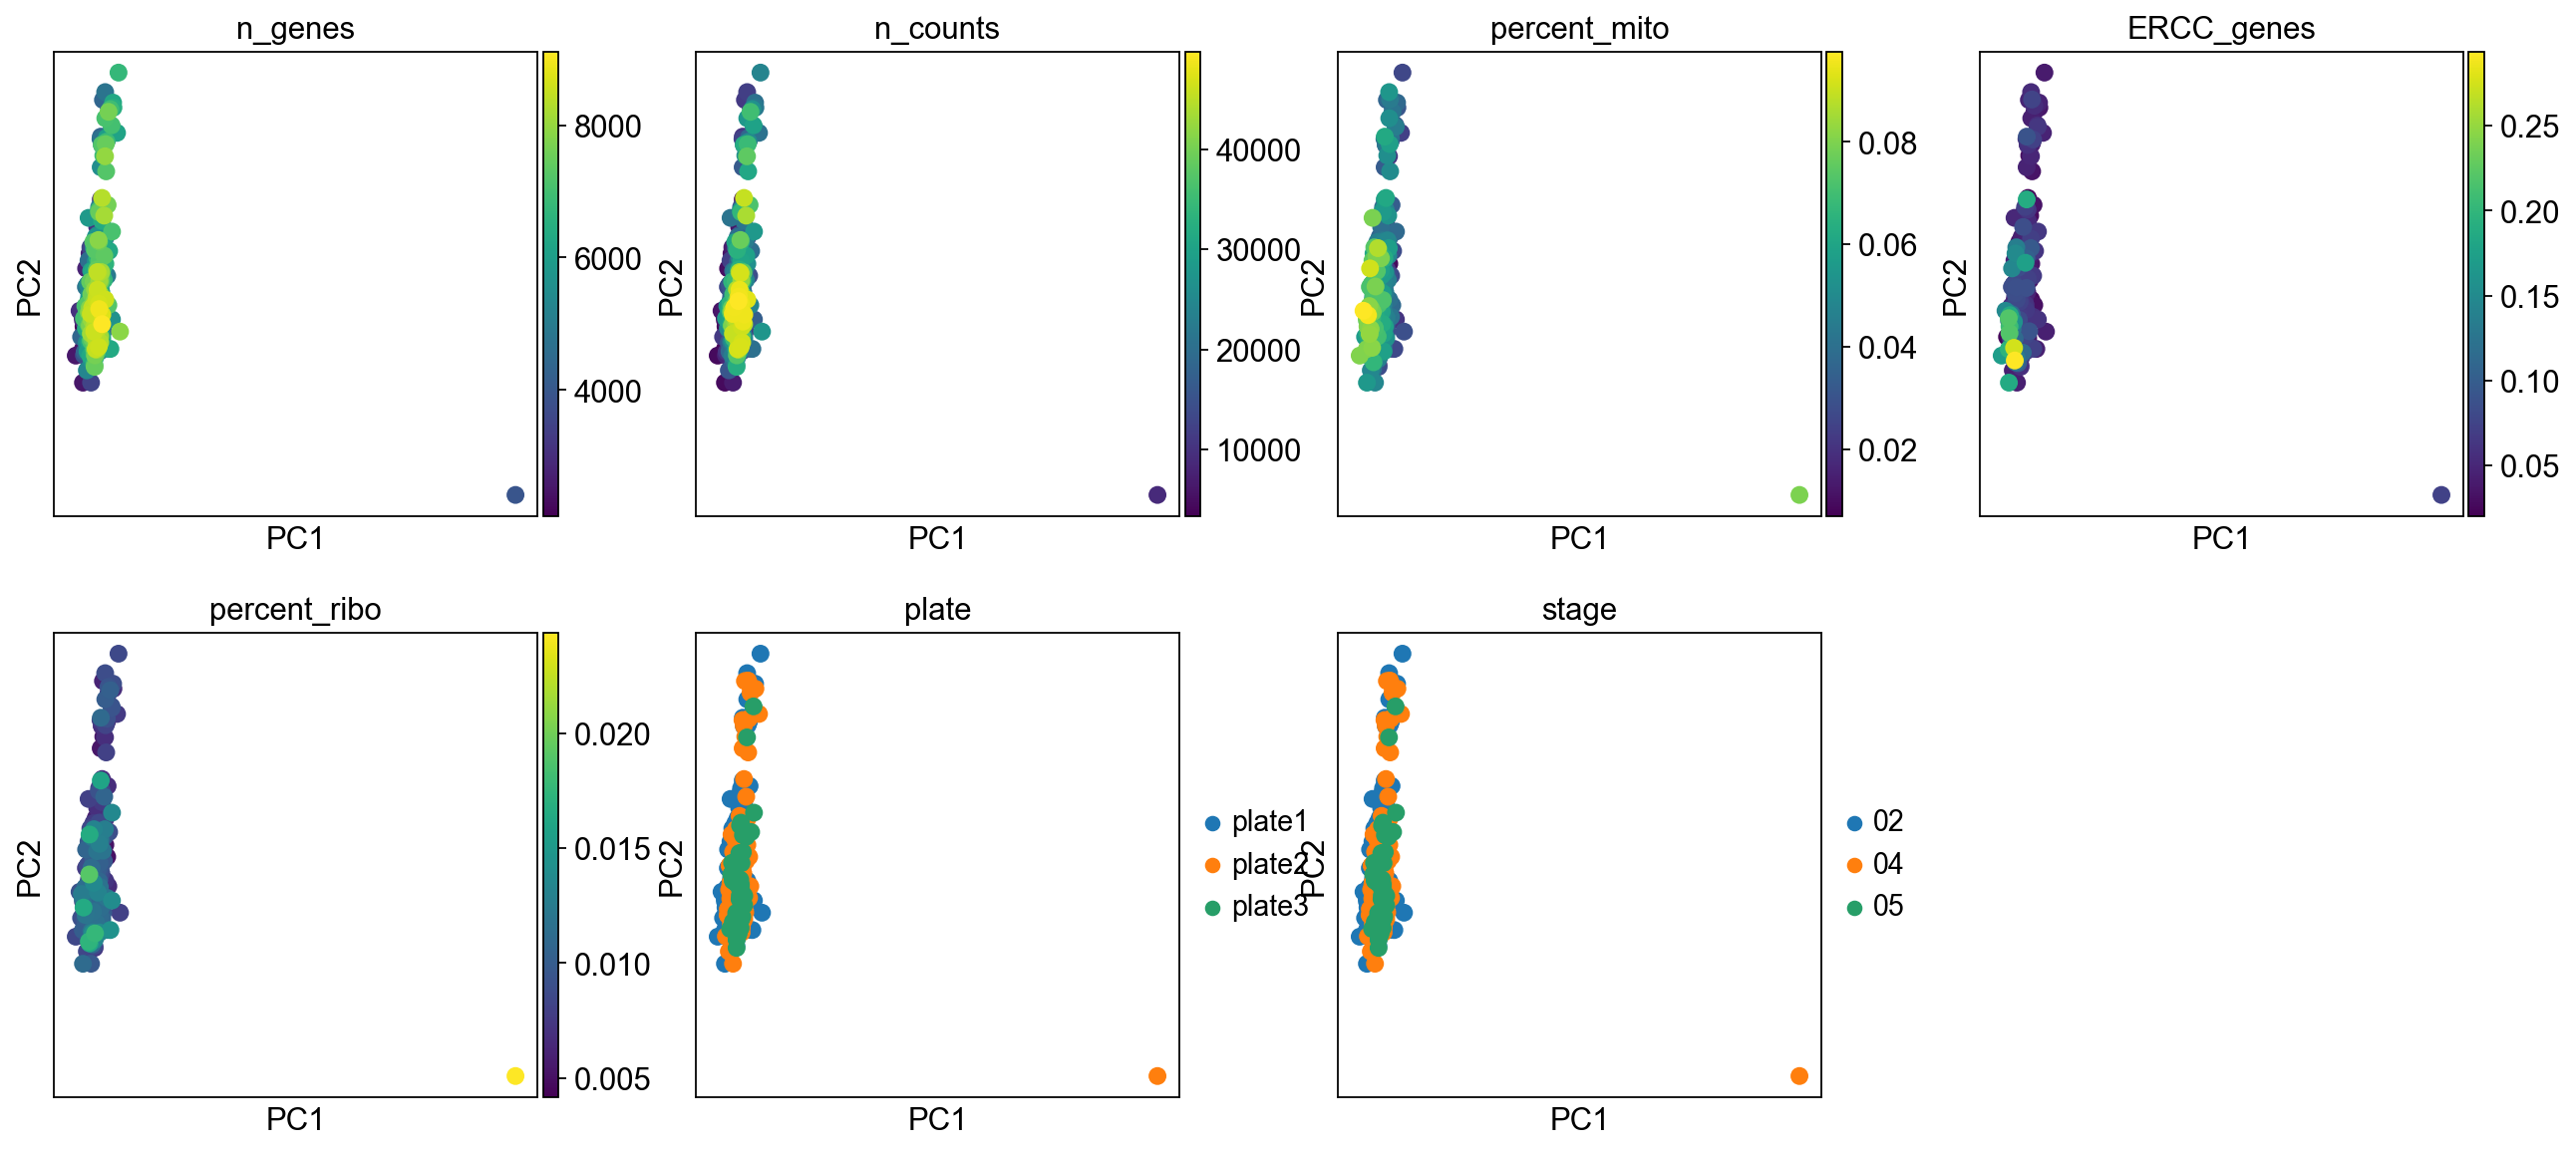

In [57]:
sc.pl.pca(adata, color=['Tal1', "Dlx1",'Dlx5', 'Neurod6', 'Six3', 'Sox14'], save = "markers_1.pdf")
sc.pl.pca(adata, color=['n_genes', 'n_counts', 'percent_mito','ERCC_genes','percent_ribo','plate', 'stage'], save = "1.pdf")

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often, a rough estimate of the number of PCs does fine.

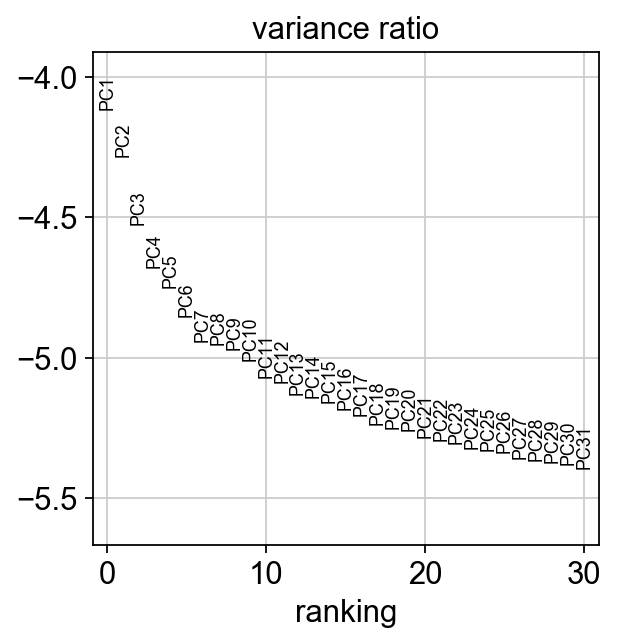

In [58]:
sc.pl.pca_variance_ratio(adata, log=True)

In [59]:
adata.write(results_file)

In [60]:
adata

AnnData object with n_obs × n_vars = 461 × 3789 
    obs: 'ERCC_genes', 'n_counts_withERCCmito', 'n_genes', 'n_counts_with_mito', 'percent_mito', 'n_counts', 'percent_ribo', 'percent_coding', 'percent_lincRNA', 'sum_lincRNA', 'percent_antisense', 'sum_antisense', 'percent_miRNA', 'sum_miRNA', 'percent_bidirectional_promoter_lncRNA', 'sum_bidirectional_promoter_lncRNA', 'percent_snoRNA', 'stage', 'plate', 'well_no', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts_norm'
    var: 'fullname', 'ENS_names', 'geneid', 'feature', 'chr', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'plate_colors', 'pca', 'stage_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'spliced

## Computing the neighborhood graph

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat's results, let's take the following values.

In [61]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:01)


## Embedding the neighborhood graph


We advertise embedding the graph in 2 dimensions using UMAP ([McInnes et al., 2018](https://arxiv.org/abs/1802.03426)), see below. It is  potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preservers trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

```
tl.paga(adata)
pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
tl.umap(adata, init_pos='paga')
```

In [62]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


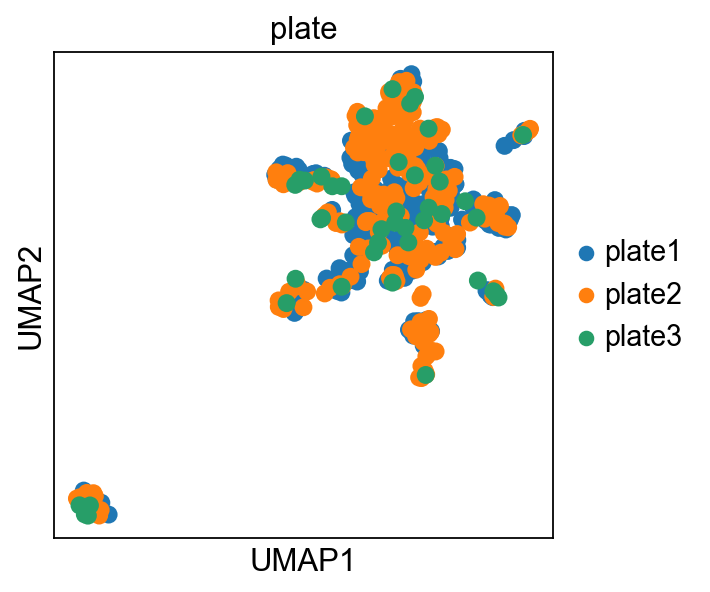

In [63]:
sc.pl.umap(adata, color=['n_genes','Actb','plate', 'stage'], use_raw=True, save = "1.pdf")#)
sc.pl.umap(adata, color=['Tal1', "Dlx1",'Dlx5', 'Neurod6', 'Six3', 'Hes1', 'Aldh1l1'], use_raw=True, save = "2.pdf")#)
sc.pl.umap(adata, color=['plate'], use_raw=True,save="_populations_umap_1.pdf")

In [64]:
sc.tl.embedding_density(adata, basis='umap', groupby='plate')

computing density on 'umap'
--> added
    'umap_density_plate', densities (adata.obs)
    'umap_density_plate_params', parameter (adata.uns)


In [65]:
sc.pl.embedding_density(adata, basis='umap', key='umap_density_plate',group=['plate1', 'plate2', 'plate3'])

In [69]:
sc.tl.tsne(adata)

computing tSNE
    using 'X_pca' with n_pcs = 50


TypeError: Callable[[arg, ...], result]: each arg must be a type. Got Ellipsis.

In [67]:
sc.pl.tsne(adata, color= ('n_genes','percent_mito','percent_ribo'), s=50) 
sc.pl.tsne(adata, color= ('plate', 'stage'), s=50) 
sc.pl.tsne(adata, color= ('n_genes','percent_mito','louvain','percent_ribo'), s=50)
sc.pl.tsne(adata, color= (['Tal1', "Dlx1",'Dlx5', 'Neurod6', 'Six3']), s=50) 

KeyError: "Could not find entry in `obsm` for 'tsne'.\nAvailable keys are: ['X_pca', 'X_umap']."

In [68]:
sc.pl.tsne(adata, color=['plate'
                        ], s=50,save="_populations_tsne_1.pdf")#)

KeyError: "Could not find entry in `obsm` for 'tsne'.\nAvailable keys are: ['X_pca', 'X_umap']."

As we set the `.raw` attribute of `adata`, the previous plots showed the "raw" (normalized, logarithmized, but uncorrected) gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don't want to use `.raw`.

## Clustering the neighborhood graph

As Seurat and many others, we recommend the Louvain graph-clustering method (community detection based on optimizing modularity). It has been proposed for single-cell data by [Levine et al. (2015)](https://doi.org/10.1016/j.cell.2015.05.047). Note that Louvain clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [82]:
sc.tl.louvain(adata)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


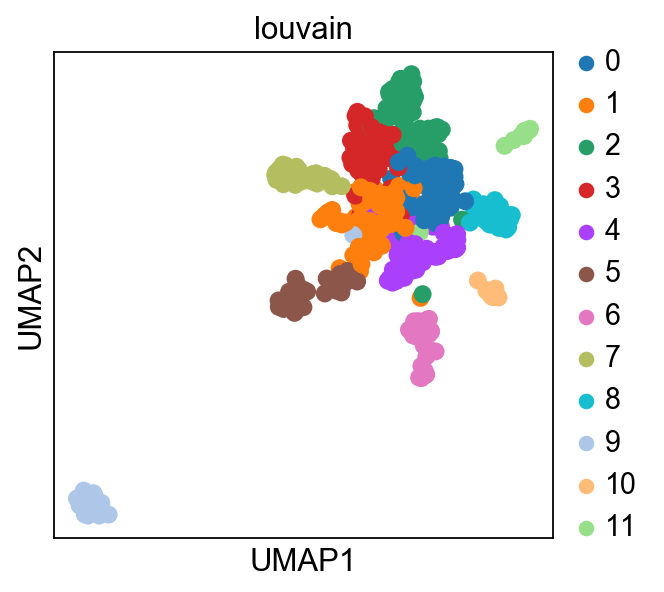

KeyError: "Could not find entry in `obsm` for 'tsne'.\nAvailable keys are: ['X_pca', 'X_umap']."

In [83]:
sc.pl.umap(adata, color=['louvain'])
sc.pl.tsne(adata, color= ('louvain'), s=50)

In [84]:
adata.write(results_file)

In [85]:
## look at marker gene overlap
sc.tl.rank_genes_groups(adata, groupby='louvain')
marker_genes =  {'Oligodendrocytes':{'Plp1'}, 'Radial Glia':{'HES1'},'Interneurons':{'Gad1'}, 'Astrocytes':{'Aldh1l1'}, 'Neurons':{'Tubb3'}}
marker_matches = sc.tl.marker_gene_overlap(adata, marker_genes)

## look at marker gene overlap
#marker_genes_overlap = {'Oligodendrocytes':{'Plp1'},'Interneurons':{'Gad1'}, 'Radial Glia':{'HES1'},'Interneurons':{'Gat1'}, 'Astrocytes':{'Aldh1l1'}, 'Neurons':{'Tubb3'}}
#marker_matches = sc.tl.marker_gene_overlap(adata, marker_genes_overlap)
## look at marker gene overlap


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


In [86]:
marker_matches

0    1    2    3    4    5    6    7    8    9   10   11
Oligodendrocytes  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
Radial Glia       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
Interneurons      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
Astrocytes        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
Neurons           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0